<a href="https://colab.research.google.com/github/previoip/tensor-exerc/blob/main/tensor_clipRecognition_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [1]:
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
import scipy
import pathlib
import os

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

from google.colab import drive

Defs

In [2]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

Load datasets

In [3]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
data_dir = "gdrive/My Drive/Colab Test Dataset/sound_datasets/dataset"
# data_dir_train = [x for x in pathlib.Path(f'{data_dir}/train').glob('**/*') if x.is_file()]
tf_data_dir_train = tf.io.gfile.glob(f'{data_dir}/train/*/*.wav')
tf_data_dir_train = tf.random.shuffle(tf_data_dir_train)


get stat

In [5]:
num_samples = len(tf_data_dir_train)
print('Number of total examples:', num_samples)
print('Example file tensor:', tf_data_dir_train[0])


Number of total examples: 872
Example file tensor: tf.Tensor(b'gdrive/My Drive/Colab Test Dataset/sound_datasets/dataset/train/snap/tr_snap-158.wav', shape=(), dtype=string)


In [6]:
classification = np.array(tf.io.gfile.listdir(f'{data_dir}/train'))
print('classification:', classification)

classification: ['clap' 'snap' 'tap']


Create Datasets

In [7]:
num_train_samples = num_samples - 200
train_files = tf_data_dir_train[:num_train_samples]
val_files = tf_data_dir_train[num_train_samples: num_train_samples + 100]
test_files = tf_data_dir_train[-100:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))


Training set size 672
Validation set size 100
Test set size 100


Preprocessing

In [8]:
def decode_audio(audio_binary):
    # Decode WAV-encoded audio files to `float32` tensors, normalized
    # to the [-1.0, 1.0] range. Return `float32` audio and a sample rate.
    audio, sample_rate = tf.audio.decode_wav(contents=audio_binary, desired_channels=1)
    # Since all the data is single channel (mono), drop the `channels`
    # axis from the array.
    return tf.squeeze(audio, axis=-1), sample_rate

def get_label(file_path):
    parts = tf.strings.split(input=[file_path], sep=os.path.sep)
    # Note: You'll use indexing here instead of tuple unpacking to enable this
    # to work in a TensorFlow graph.
    # return parts[-2]
    return parts.values[-2]

In [9]:
def ensure_sample_rate(original_sample_rate, waveform,
                       desired_sample_rate=16000):
  """Resample waveform if required."""
  if original_sample_rate != desired_sample_rate:
    desired_length = int(round(float(len(waveform)) / original_sample_rate * desired_sample_rate))
    waveform = scipy.signal.resample(waveform, desired_length)
  
  return tf.convert_to_tensor(waveform, dtype=tf.float32)

In [10]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform, sample_rate = decode_audio(audio_binary)
  # waveform = ensure_sample_rate(original_sample_rate= int(sample_rate), waveform=waveform)
  return tf.convert_to_tensor(waveform, dtype=tf.float32), label

In [11]:
get_waveform_and_label(train_files[0])

(<tf.Tensor: shape=(24000,), dtype=float32, numpy=
 array([ 0.03314209,  0.0307312 ,  0.02728271, ..., -0.00418091,
        -0.00744629, -0.00872803], dtype=float32)>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'snap'>)

create dataset

In [12]:
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
AUTOTUNE = tf.data.AUTOTUNE
waveform_ds = files_ds.map(map_func=get_waveform_and_label)

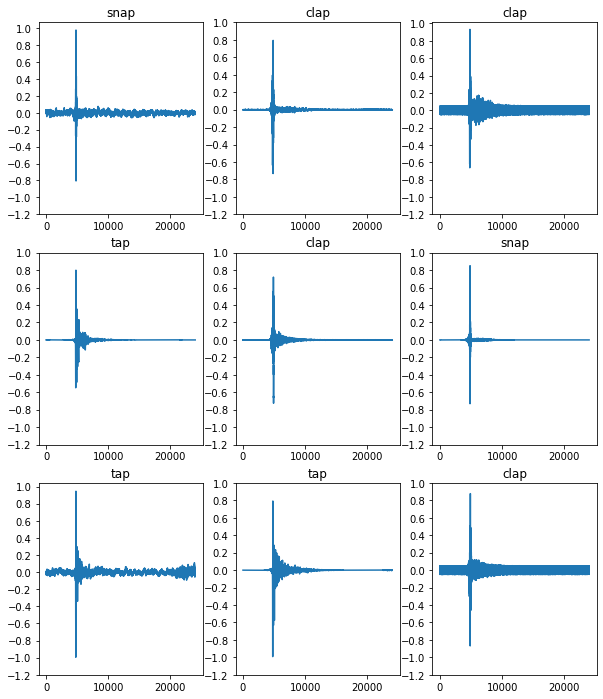

In [13]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()


In [14]:
def get_spectrogram(waveform):
  # Zero-padding for an audio waveform with less than 16,000 samples.
  input_len = 16000
  waveform = waveform[:input_len]
  zero_padding = tf.zeros(
      [16000] - tf.shape(waveform),
      dtype=tf.float32)
  # Cast the waveform tensors' dtype to float32.
  waveform = tf.cast(waveform, dtype=tf.float32)
  # Concatenate the waveform with `zero_padding`, which ensures all audio
  # clips are of the same length.
  equal_length = tf.concat([waveform, zero_padding], 0)
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [15]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=24000))


Label: snap
Waveform shape: (24000,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [16]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)


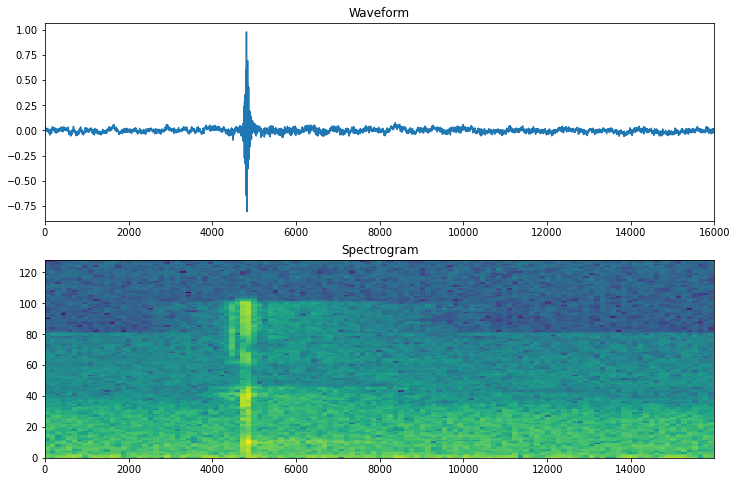

In [17]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()


In [18]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  label_id = tf.argmax(label == classification)
  return spectrogram, label_id

In [19]:
spectrogram_ds = waveform_ds.map(
  map_func=get_spectrogram_and_label_id,
  num_parallel_calls=AUTOTUNE)

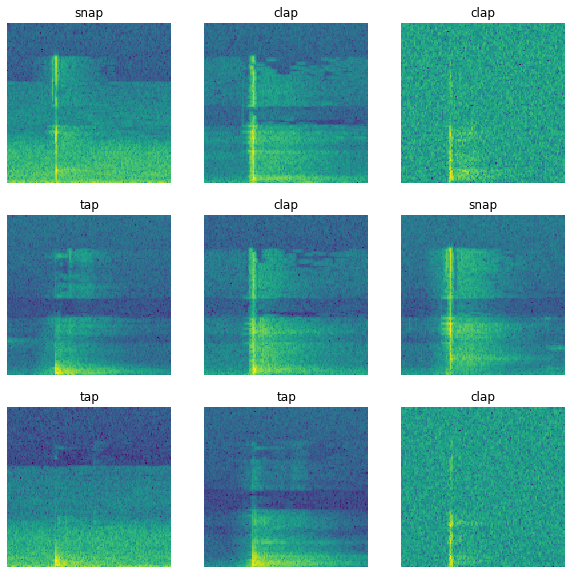

In [20]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(spectrogram.numpy(), ax)
  ax.set_title(classification[label_id.numpy()])
  ax.axis('off')

plt.show()


train begin

In [21]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(
      map_func=get_waveform_and_label,
      num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      map_func=get_spectrogram_and_label_id,
      num_parallel_calls=AUTOTUNE)
  return output_ds

In [22]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)


In [23]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [24]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [25]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(classification)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()


Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           

In [26]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)


In [27]:
EPOCHS = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)


Epoch 1/10
11/11 [==============================] - 15s 1s/step - loss: 0.5648 - accuracy: 0.7351 - val_loss: 0.2009 - val_accuracy: 0.9300
Epoch 2/10
11/11 [==============================] - 2s 222ms/step - loss: 0.1440 - accuracy: 0.9479 - val_loss: 0.1175 - val_accuracy: 0.9600
Epoch 3/10
11/11 [==============================] - 2s 222ms/step - loss: 0.0982 - accuracy: 0.9658 - val_loss: 0.0541 - val_accuracy: 0.9800
Epoch 4/10
11/11 [==============================] - 5s 460ms/step - loss: 0.1075 - accuracy: 0.9583 - val_loss: 0.0816 - val_accuracy: 0.9700
Epoch 5/10
11/11 [==============================] - 4s 347ms/step - loss: 0.0902 - accuracy: 0.9658 - val_loss: 0.1332 - val_accuracy: 0.9500
Epoch 00005: early stopping


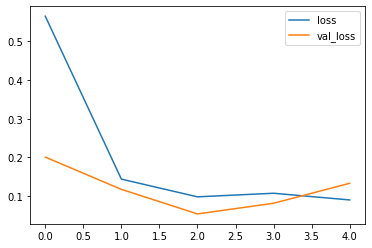

In [28]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()


In [29]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)


In [30]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')


Test set accuracy: 98%


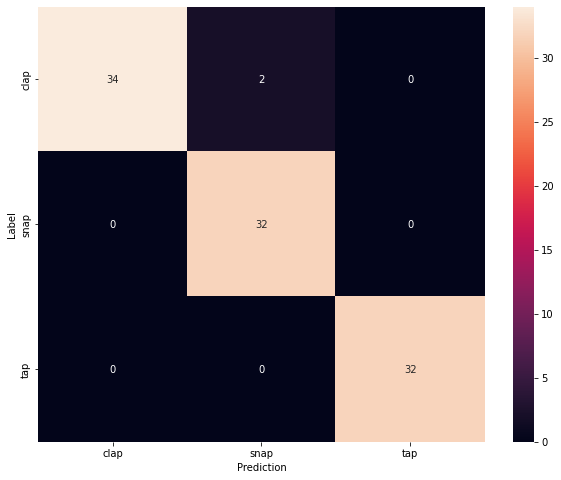

In [31]:
import seaborn as sns
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=classification,
            yticklabels=classification,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()


In [32]:
#@title Select Custom Sample


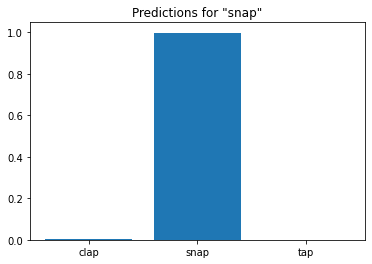

In [34]:
sample_file = f'{data_dir}/test/snap/snap_test.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(classification, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{classification[label[0]]}"')
  plt.show()
